# NMSLIB for CBIR

In [1]:
import numpy as np
import nmslib 
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Mock dataset

In [2]:
def gen_data(data_size=100,mean=[0,0],var=[1,1]):
    means=np.array(mean)
    sigmas=np.array(var)
    return np.random.normal(means,sigmas,(data_size,2))

In [3]:
def gen_dataset(data_size=100):
    data0=gen_data(data_size=data_size,mean=[-5,-5])
    label0=np.full(data_size,0)
    
    data1=gen_data(data_size=data_size,mean=[1-5,8-5])
    label1=np.full(data_size,1)
    
    data2=gen_data(data_size=data_size,mean=[5-5,5-5])
    label2=np.full(data_size,2)
    
    data3=gen_data(data_size=data_size,mean=[13-5,9-5]) 
    label3=np.full(data_size,3)
    
    data4=gen_data(data_size=data_size,mean=[11-5,3-5]) 
    label4=np.full(data_size,4)
    
    data5=gen_data(data_size=data_size,mean=[-1-5,15-5]) 
    label5=np.full(data_size,4)
    
    data6=gen_data(data_size=data_size,mean=[7-5,-5-5]) 
    label6=np.full(data_size,4)
    
    return (np.vstack([data0,data1,data2,data3,data4,data5,data6]),np.vstack([label0,label1,label2,label3,label4,label5,label6]).flatten())

In [4]:
data,labels=gen_dataset()

xx, yy = np.meshgrid(np.linspace(-20,20,100), np.linspace(-20,20,100))
grid=np.stack((xx,yy),axis=2)
query_data=grid.reshape((-1,2))

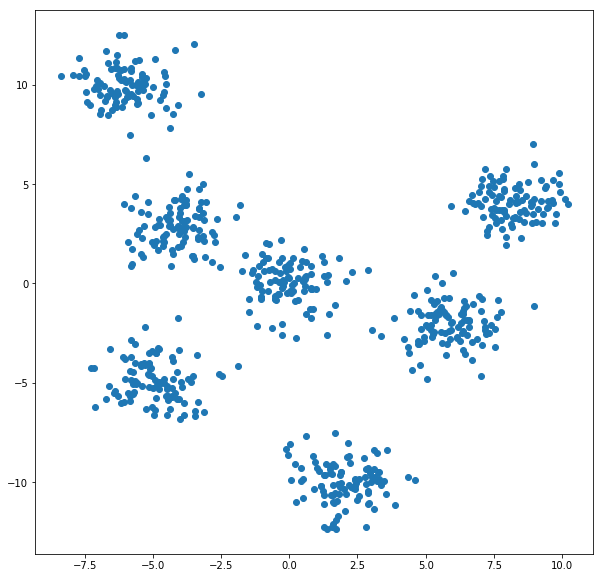

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1])

# Util

In [6]:
import numbers
def _add_data_to_index(index,data,indexes,data_batch):
    if type(indexes) is list:
        offset=indexes[0]
    elif isinstance(indexes, numbers.Number):
        offset=indexes
    else:
        offset=0 
    for data_batch in np.split(data,data_batch,axis=0):
        indices=np.arange(len(data_batch),dtype=np.int32)+offset
        nmslib.addDataPointBatch(index,indices,data_batch)
        offset+=data_batch.shape[0]
    return offset

class CBIMIndexSpaceTypes:
    L1='l1'
    L2='l2'
    ANGULAR_DISTANCE='angulardist'
    COSINE_SIMILARITY='cosinesimil'
    DEFAULT=COSINE_SIMILARITY
    
class CBIMIndexSpaceParam:
    KNN=['knn=1']
    RANGE=['range=1.0']
    BOTH=['knn=1','range=1.0']
    DEFAULT=KNN
    
class CBIMIndexMethodNames:
    VP_TREE='vptree'
    MVP_TREE='mvptree'
    GH_TREE='ghtree'
    LIST_OF_CLUSTERS='list_clusters'
    SA_TREE='satree'
    BB_TREE='bbtree'
    SW_GRAPH='sw-graph'
    HIERARCHICAL_NAVIGABLE_SW_GRAPH='hnsw'
    NN_DESCENT='nndes'
    DEFAULT=VP_TREE
    
def index_param_factory(method_name):

    if method_name is CBIMIndexMethodNames.VP_TREE:
        return {
            'bucketSize':10,
            'chunkBucket':1,
            'selectPivotAttempts':5
        }
    if method_name is CBIMIndexMethodNames.MVP_TREE:
        return {
            'bucketSize':10,
            'chunkBucket':1,
            'maxPathLen':20
        }
    if method_name is CBIMIndexMethodNames.GH_TREE:
        return {
            'bucketSize':10,
            'chunkBucket':1
        }
    if method_name is CBIMIndexMethodNames.LIST_OF_CLUSTERS:
        return {
            'bucketSize':10,
            'chunkBucket':1,
            'useBucketSize':0,
            'radius':0.5,
            'strategy':'random' # can_be: 'random','closestPrevCenter','farthestPrevCenter','minSumDistPrevCenters','maxSumDistPrevCenters'

            }
    if method_name is CBIMIndexMethodNames.SA_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.BB_TREE:
        return {            
            'bucketSize':10,
            'chunkBucket':1
        }
    if method_name is CBIMIndexMethodNames.SW_GRAPH:
        return {            
            'NN':3,
            'initIndexAttempts':5,
            'indexThreadQty':4
        }
    if method_name is CBIMIndexMethodNames.HIERARCHICAL_NAVIGABLE_SW_GRAPH:
        return {            
            'M':10,
            'efConstruction':20,
            'indexThreadQty':4,
            'searchMethod':5
        }
    if method_name is CBIMIndexMethodNames.NN_DESCENT:
        return {            
            'NN':10,
            'rho':0.5,
            'delta':0.001
        }
    return {}

def query_time_param_factory(method_name):
    if method_name is CBIMIndexMethodNames.VP_TREE:
        return {
            'alphaLeft':2.0,
            'alphaRight':2.0,
            'expLeft':1,
            'expRight':1,
            'maxLeavesToVisit':2147483647
        }
    if method_name is CBIMIndexMethodNames.MVP_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.GH_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.LIST_OF_CLUSTERS:
        return {}
    if method_name is CBIMIndexMethodNames.SA_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.BB_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.SW_GRAPH:
        return {            
            'initSearchAttempts':1,
            'efSearch':10
        }
    if method_name is CBIMIndexMethodNames.HIERARCHICAL_NAVIGABLE_SW_GRAPH:
        return {            
            'efSearch':10
        }
    if method_name is CBIMIndexMethodNames.NN_DESCENT:
        return {            
            'initSearchAttempts':3
        }
    return {}


def  params_to_list(index_param):
    params=[]
    for key, value in index_param.iteritems():
        params.append(str(key)+'='+str(value))
    return params
    
def print_params(index_param):
    for key, value in index_param.iteritems():
        print str(key)+'='+str(value)

In [7]:

class CBIMConf:
    '''
    Config file for index creation.
    '''
    space_type = None
    space_param = None
    method_name = None
    index_param = None
    query_time_param = None
    
    def __init__(self,space_type=CBIMIndexSpaceTypes.DEFAULT,
                 space_param=CBIMIndexSpaceParam.DEFAULT,
                 method_name=CBIMIndexMethodNames.DEFAULT):          
        self.space_type = space_type
        self.space_param = space_param
        self.method_name = method_name
        self.index_param = params_to_list(index_param_factory(method_name))
        self.query_time_param =  params_to_list(query_time_param_factory(method_name))  

class CBIMIndex:
    index=None
    conf=None
    created=False
    
    def __init__(self,cbim_conf):
        self.conf=cbim_conf
        print cbim_conf.space_type
        print cbim_conf.space_param
        print cbim_conf.method_name
        
        self.index = nmslib.init(cbim_conf.space_type,
                        cbim_conf.space_param,
                        cbim_conf.method_name,
                        nmslib.DataType.DENSE_VECTOR,
                        nmslib.DistType.FLOAT)

    def add_data(self,data,indexes=None,batch_size=100,convert=False):
        if self.created:
            return -1
        if data.dtype is not 'float32':
            if not convert:
                print 'WARNING: Given data is not of type float32.'
                print '\tEnable conversion with flag convert=True to cast data or give float32 data for nmslib to work properly.'
                return -1
            else:
                data=data.astype(np.float32)
        return _add_data_to_index(self.index,data,indexes,batch_size)
    
    def create(self):
        if self.created:
            return False
        else:
            nmslib.createIndex(self.index, self.conf.index_param)
            nmslib.setQueryTimeParams(self.index,self.conf.query_time_param)
            self.created=True
            return True
    
    def query(self,query_data,top_k=3,convert=False,num_threads = 4):
        if not self.created:
            return -1
        if query_data.dtype is not 'float32':
            if not convert:
                print 'WARNING: Given query data is not of type float32.'
                print '\tEnable conversion with flag convert=True to cast query data or give float32 query data for nmslib to work properly.'
                return -1
            else:
                query_data=query_data.astype(np.float32)
        
        return nmslib.knnQueryBatch(self.index, num_threads, top_k, query_data)
    
    def pickle(self,path):
        pickle.dump(self, open(path,'wb'))
    
    def clr_mem(self):
        nmslib.freeIndex(self.index)
        self.created=False
        
def CBIMIndex_unpickle(path):
    return pickle.load(open(path,'rb'))
        

In [8]:
def evaluate(data,query_data,conf):
    index=CBIMIndex(conf)
    index.add_data(data,batch_size=5,convert=True)
    index.create()
    query_res=index.query(query_data=query_data,top_k=1,convert=True)
    index.clr_mem()
    
    return query_res
    

In [9]:
def show_res(res,labels):
    res_labels=map(lambda i:labels[i],res)
    res_labels=np.array(res_labels).reshape((100,100))
    plt.figure(figsize=(10,10))
    plt.imshow(res_labels, origin='lower', interpolation='none')
    
def eval_and_show(data,labels,query_data,conf):
    res=evaluate(data,query_data,conf)
    show_res(res,labels)

# Space partitioning methods

cosinesimil
['knn=1']
vptree


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


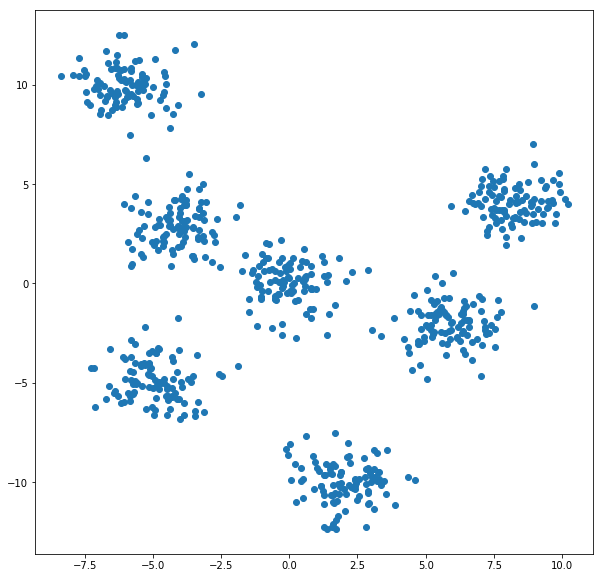

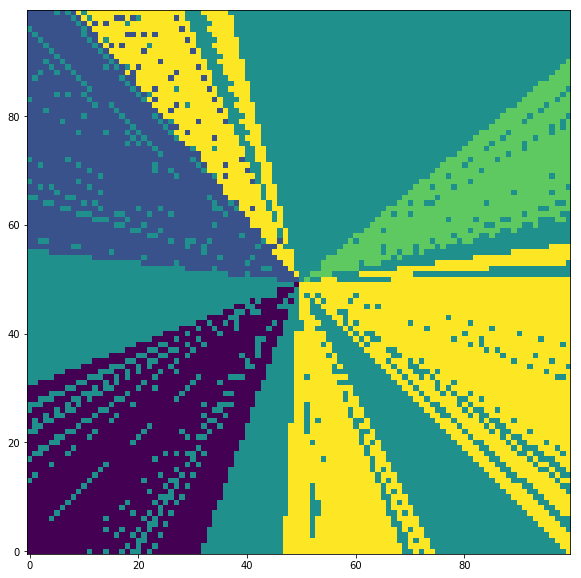

In [10]:
# Test VP-tree
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1])
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.VP_TREE)
eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
mvptree


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


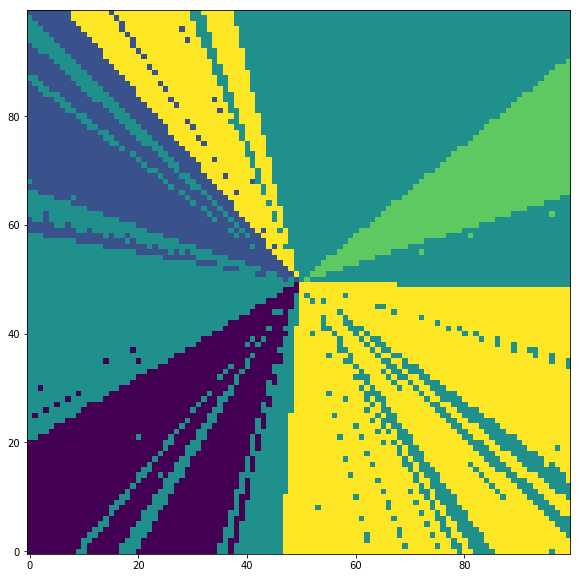

In [11]:
# Test MVP-tree
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.MVP_TREE)
eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
ghtree


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


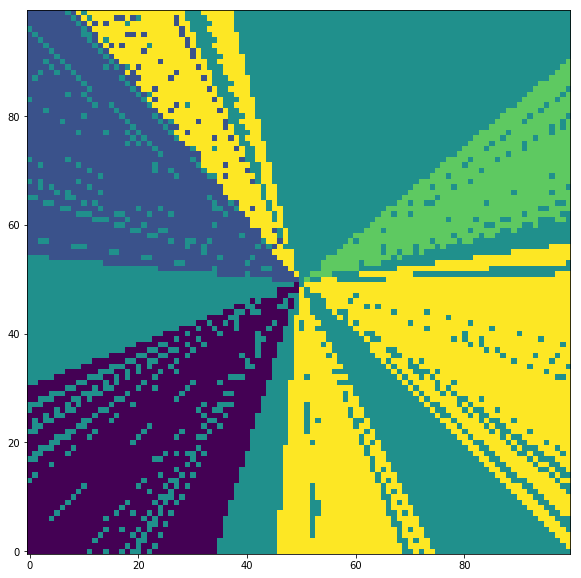

In [12]:
# Test GH-tree
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.GH_TREE)
eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
list_clusters


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


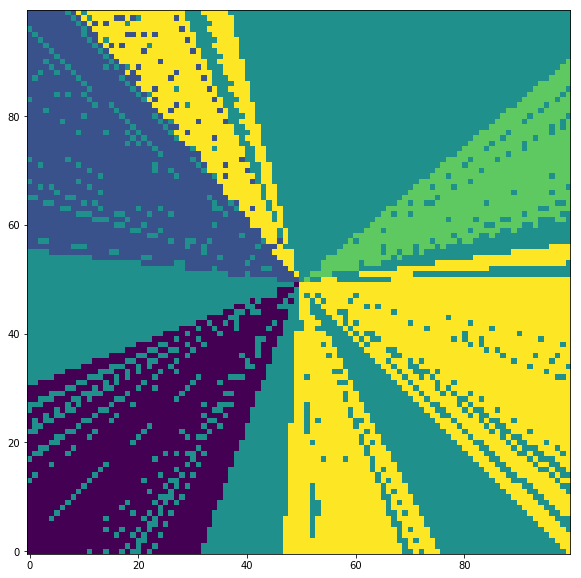

In [13]:
# Test list of clusters
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.LIST_OF_CLUSTERS)
eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
satree


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


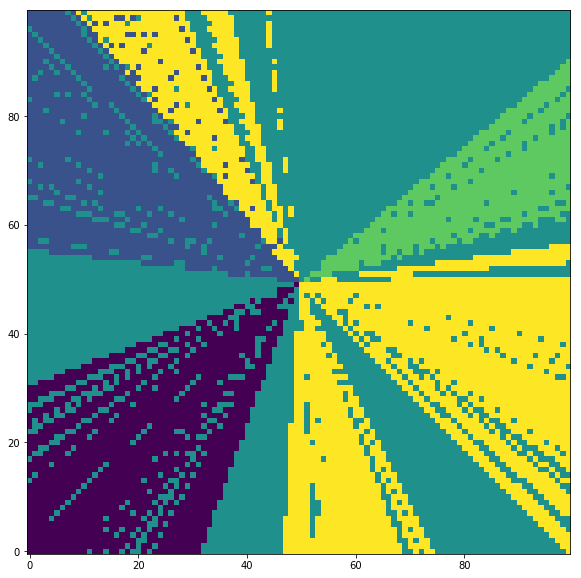

In [14]:
# Test SA-tree
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.SA_TREE)
eval_and_show(data,labels,query_data,conf)

In [15]:
# Nije primjenjiv; zahtjeva metriku KL divergencije za slicnost,
# s cime se ne bi htio igrati u ovom trenutku

# # Test bb-tree
# conf=CBIMConf(CBIMIndexSpaceTypes.L2,
#               CBIMIndexSpaceParam.DEFAULT,
#               CBIMIndexMethodNames.BB_TREE)
# eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
sw-graph


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


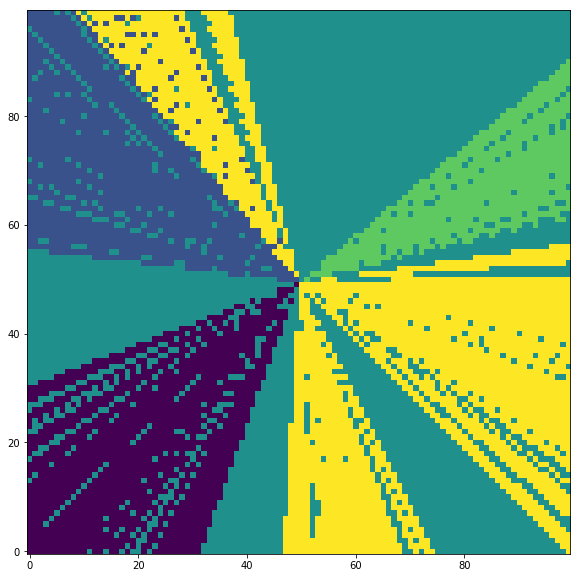

In [16]:
# Test SW-graph
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.SW_GRAPH)
eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
hnsw


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


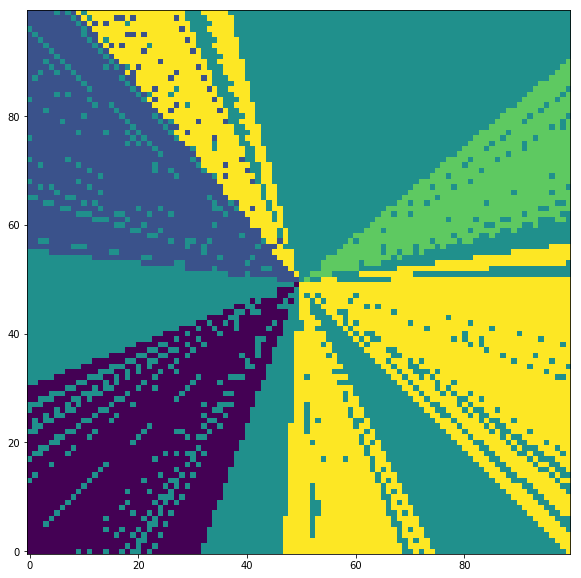

In [17]:
# Test Hierarchical navigable SW-graph
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.HIERARCHICAL_NAVIGABLE_SW_GRAPH)
eval_and_show(data,labels,query_data,conf)

cosinesimil
['knn=1']
nndes


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


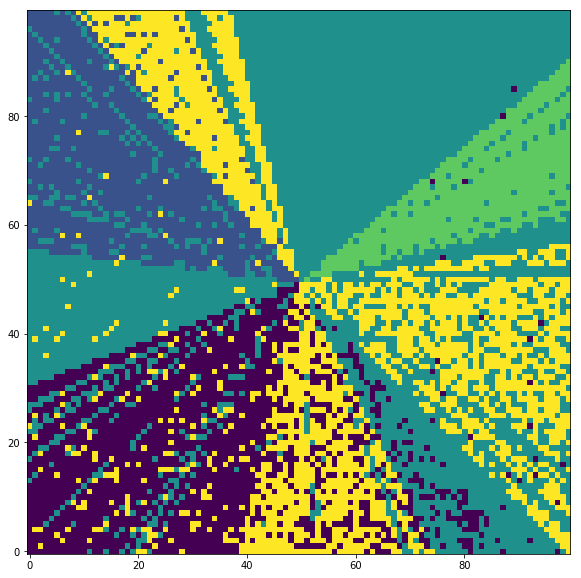

In [18]:
# Test NN-descent
conf=CBIMConf(CBIMIndexSpaceTypes.COSINE_SIMILARITY,
              CBIMIndexSpaceParam.DEFAULT,
              CBIMIndexMethodNames.NN_DESCENT)
eval_and_show(data,labels,query_data,conf)

# Conclusion (all in one place)

In [19]:
import numpy as np
import nmslib 
import pickle
import numbers

class CBIMIndexSpaceTypes:
    L1='l1'
    L2='l2'
    ANGULAR_DISTANCE='angulardist'
    COSINE_SIMILARITY='cosinesimil'
    DEFAULT=COSINE_SIMILARITY
    
class CBIMIndexSpaceParam:
    KNN=['knn=1']
    RANGE=['range=1.0']
    BOTH=['knn=1','range=1.0']
    DEFAULT=KNN
    
class CBIMIndexMethodNames:
    VP_TREE='vptree'
    MVP_TREE='mvptree'
    GH_TREE='ghtree'
    LIST_OF_CLUSTERS='list_clusters'
    SA_TREE='satree'
    BB_TREE='bbtree'
    SW_GRAPH='sw-graph'
    HIERARCHICAL_NAVIGABLE_SW_GRAPH='hnsw'
    NN_DESCENT='nndes'
    DEFAULT=VP_TREE
    
def index_param_factory(method_name):

    if method_name is CBIMIndexMethodNames.VP_TREE:
        return {
            'bucketSize':10,
            'chunkBucket':1,
            'selectPivotAttempts':5
        }
    if method_name is CBIMIndexMethodNames.MVP_TREE:
        return {
            'bucketSize':10,
            'chunkBucket':1,
            'maxPathLen':20
        }
    if method_name is CBIMIndexMethodNames.GH_TREE:
        return {
            'bucketSize':10,
            'chunkBucket':1
        }
    if method_name is CBIMIndexMethodNames.LIST_OF_CLUSTERS:
        return {
            'bucketSize':10,
            'chunkBucket':1,
            'useBucketSize':0,
            'radius':0.5,
            'strategy':'random' # can_be: 'random','closestPrevCenter','farthestPrevCenter','minSumDistPrevCenters','maxSumDistPrevCenters'

            }
    if method_name is CBIMIndexMethodNames.SA_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.BB_TREE:
        return {            
            'bucketSize':10,
            'chunkBucket':1
        }
    if method_name is CBIMIndexMethodNames.SW_GRAPH:
        return {            
            'NN':3,
            'initIndexAttempts':5,
            'indexThreadQty':4
        }
    if method_name is CBIMIndexMethodNames.HIERARCHICAL_NAVIGABLE_SW_GRAPH:
        return {            
            'M':10,
            'efConstruction':20,
            'indexThreadQty':4,
            'searchMethod':5
        }
    if method_name is CBIMIndexMethodNames.NN_DESCENT:
        return {            
            'NN':10,
            'rho':0.5,
            'delta':0.001
        }
    return {}

def query_time_param_factory(method_name):
    if method_name is CBIMIndexMethodNames.VP_TREE:
        return {
            'alphaLeft':2.0,
            'alphaRight':2.0,
            'expLeft':1,
            'expRight':1,
            'maxLeavesToVisit':2147483647
        }
    if method_name is CBIMIndexMethodNames.MVP_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.GH_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.LIST_OF_CLUSTERS:
        return {}
    if method_name is CBIMIndexMethodNames.SA_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.BB_TREE:
        return {}
    if method_name is CBIMIndexMethodNames.SW_GRAPH:
        return {            
            'initSearchAttempts':1,
            'efSearch':10
        }
    if method_name is CBIMIndexMethodNames.HIERARCHICAL_NAVIGABLE_SW_GRAPH:
        return {            
            'efSearch':10
        }
    if method_name is CBIMIndexMethodNames.NN_DESCENT:
        return {            
            'initSearchAttempts':3
        }
    return {}


def  params_to_list(index_param):
    params=[]
    for key, value in index_param.iteritems():
        params.append(str(key)+'='+str(value))
    return params
    
def print_params(index_param):
    for key, value in index_param.iteritems():
        print str(key)+'='+str(value)
        

class CBIMConf:
    '''
    Config file for index creation.
    '''
    space_type = None
    space_param = None
    method_name = None
    index_param = None
    query_time_param = None
    
    def __init__(self,space_type=CBIMIndexSpaceTypes.DEFAULT,
                 space_param=CBIMIndexSpaceParam.DEFAULT,
                 method_name=CBIMIndexMethodNames.DEFAULT):          
        self.space_type = space_type
        self.space_param = space_param
        self.method_name = method_name
        self.index_param = params_to_list(index_param_factory(method_name))
        self.query_time_param =  params_to_list(query_time_param_factory(method_name))  

class CBIMIndex:
    index=None
    conf=None
    created=False
    
    def __init__(self,cbim_conf):
        self.conf=cbim_conf
        print cbim_conf.space_type
        print cbim_conf.space_param
        print cbim_conf.method_name
        
        self.index = nmslib.init(cbim_conf.space_type,
                        cbim_conf.space_param,
                        cbim_conf.method_name,
                        nmslib.DataType.DENSE_VECTOR,
                        nmslib.DistType.FLOAT)

    def add_data(self,data,indexes=None,batch_size=100,convert=False):
        if self.created:
            return -1
        if data.dtype is not 'float32':
            if not convert:
                print 'WARNING: Given data is not of type float32.'
                print '\tEnable conversion with flag convert=True to cast data or give float32 data for nmslib to work properly.'
                return -1
            else:
                data=data.astype(np.float32)
        return self._add_data_to_index(data,indexes,batch_size)
    
    def _add_data_to_index(self,data,indexes,batch_size):
        if type(indexes) is list:
            offset=indexes[0]
        elif isinstance(indexes, numbers.Number):
            offset=indexes
        else:
            offset=0 
        for data_batch in np.split(data,batch_size,axis=0):
            indices=np.arange(len(data_batch),dtype=np.int32)+offset
            nmslib.addDataPointBatch(self.index,indices,data_batch)
            offset+=data_batch.shape[0]
        return offset

    
    def create(self):
        if self.created:
            return False
        else:
            nmslib.createIndex(self.index, self.conf.index_param)
            nmslib.setQueryTimeParams(self.index,self.conf.query_time_param)
            self.created=True
            return True
    
    def query(self,query_data,top_k=3,convert=False,num_threads = 4):
        if not self.created:
            return -1
        if query_data.dtype is not 'float32':
            if not convert:
                print 'WARNING: Given query data is not of type float32.'
                print '\tEnable conversion with flag convert=True to cast query data or give float32 query data for nmslib to work properly.'
                return -1
            else:
                query_data=query_data.astype(np.float32)
        
        return nmslib.knnQueryBatch(self.index, num_threads, top_k, query_data)
    
    def pickle(self,path):
        pickle.dump(self, open(path,'wb'))
    
    def clr_mem(self):
        nmslib.freeIndex(self.index)
        self.created=False
        
def CBIMIndex_unpickle(path):
    return pickle.load(open(path,'rb'))
        

In [20]:
def create_index(data,conf=None,batch_size=5,convert=False):
    '''
    NMSLIB knows how to work only with 32bit data, so a conversion is needed for it to work properly. 
    '''
    if conf is None:
        conf=CBIMConf()
    index=CBIMIndex(conf)
    status=index.add_data(data,batch_size=batch_size,convert=convert)
    if status is not -1:
        index.create()
        return index
    else:
        return None
    
def query_index(index,query,top_k=3,convert=False):
    return index.query(query_data=query,top_k=top_k,convert=convert)

*NOTE*: Po zavrsetku rada pozovi `index.clr_mem()` da ga oslobodis iz memorije. NMSLIB ima svoj save ali problem s njim je sto moras najprije konfigurirati index a tek onda restorati. Ako konfiguracije ne pasu puca, pa je prakticnije koristiti samo pickle. 

## API

In [25]:
index=create_index(data,convert=True)

cosinesimil
['knn=1']
vptree


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:190: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:190: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


In [26]:
query_index(index,query_data,convert=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:215: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:215: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


array([[ 93,  56,  65],
       [ 65,  36,  38],
       [ 24,   3,  38],
       ..., 
       [294, 253, 270],
       [294, 253, 245],
       [294, 245, 253]], dtype=int32)

In [24]:
index.clr_mem()